In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [2]:
def LagguerreRSI(data, gamma):
    # Create base data structures
    out = pd.DataFrame(index = data.index, 
                      columns = ['RSI']) 
    l =[np.zeros(4), [data.iloc[0]]*4]
    cu =np.zeros(3)
    cd =np.zeros(3)
    for i in data.index:
        # Different calculation for if it is the first price value
        l[0][0] = ((1-gamma)*data[i]) + (gamma*l[1][0])
        l[0][1] = ((-gamma)*l[0][0]) + l[1][0] + (gamma*l[1][1])
        l[0][2] = ((-gamma)*l[0][1]) + l[1][1] + (gamma*l[1][2])
        l[0][3] = ((-gamma)*l[0][2]) + l[1][2] + (gamma*l[1][3])
        # Calculate the Count Up and Count Down   
        cu[0] = l[0][0] - l[0][1] if l[0][0] >= l[0][1] else 0
        cu[1] = cu[0] + (l[0][1] - l[0][2]) if l[0][1] >= l[0][2] else cu[0]
        cu[2] = cu[1] + (l[0][2] - l[0][3]) if l[0][2] >= l[0][3] else cu[1]
        
        cd[0] = 0 if l[0][0] >= l[0][1] else l[0][1] - l[0][0]
        cd[1] = cd[0] if l[0][1] >= l[0][2] else cd[0] + (l[0][2] -l[0][1])
        cd[2] = cd[1] if l[0][2] >= l[0][3] else cd[1] + (l[0][3] - l[0][2])
        # Calculate the RSI from the final CU and CD
        out.loc[i,'RSI'] = cu[2]/(cu[2] + cd[2]) if (cu[2] + cd[2]) != 0 else 0
        # Store the Laguerre values to another list so previous values can be reffed
        l[1] = l[0]
        l[0] = np.zeros(4)
                
    return out

def LaguerreFilter(data, input_alpha, n=5, adaptive=True):
    df = pd.DataFrame(index = data.index, 
                      columns = ['LF_Change', 'alpha'])
    l =[np.zeros(4), [data[0]]*4]
    
    for i in range(len(data)):
        if i > n and adaptive:
#             Tracer()()
            # list of difference values between Filter and Actual
            comp_values = abs(df.loc[range(i-n,i),'LF'] - data[range(i-n,i)])
            # Min difference between Filter and Actual
            min_val = comp_values.min()
            # Max difference between Filter and Actual
            max_val = comp_values.max()
            # Sum of the differences
            sum_vals = comp_values.sum()
            # (actual value - min)/(max-min)
            values = (comp_values-min_val)/(max_val-min_val)
            if min_val == max_val:
                alpha = 1
            elif sum_vals == 0:
                alpha = 0
            else:
                alpha = clamp(np.median(values.dropna()),0,1)
        else:
            alpha = input_alpha
        df.loc[i, 'alpha'] = alpha
        j = i - 1
        #print [i,j]
        l[0][0] = (alpha*data[i])+((1-alpha)*l[1][0])
        l[0][1] = -((1-alpha)*l[0][0])+l[1][0]+((1-alpha)*l[1][1])
        l[0][2] = -((1-alpha)*l[0][1])+l[1][1]+((1-alpha)*l[1][2])
        l[0][3] = -((1-alpha)*l[0][2])+l[1][2]+((1-alpha)*l[1][3])
        df.loc[i,'LF'] = (l[0][0]+(2*l[0][1])+(2*l[0][2])+l[0][3])/6
        if i > 1:
            df.loc[i, 'LF_Change'] = df.loc[i,'LF'] - df.loc[j,'LF']
                
        l[1] = l[0]
        l[0] = np.zeros(4)      
                
    return df


In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, RepeatVector,TimeDistributed, Input, Concatenate
from tensorflow.keras.layers import LSTM, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
import pandas as pd
import yfinance as yf
from yahoofinancials import *


import pywt
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
import string

letters = string.ascii_uppercase
tickers = []
for letter in letters:
    res = requests.get("http://eoddata.com/stocklist/NYSE/%s.htm" % letter)
    soup = BeautifulSoup(res.content,"html.parser")
    table = soup.find_all('table')[5] 
    tickers = tickers + pd.read_html(str(table))[0]['Code'].to_list()

    

In [7]:
tickers

['A',
 'AA',
 'AAN',
 'AAP',
 'AAT',
 'AB',
 'ABB',
 'ABBV',
 'ABC',
 'ABEV',
 'ABG',
 'ABM',
 'ABR',
 'ABR-A',
 'ABR-B',
 'ABR-C',
 'ABT',
 'AC',
 'ACA',
 'ACB',
 'ACC',
 'ACCO',
 'ACE.W',
 'ACEL',
 'ACH',
 'ACI',
 'ACM',
 'ACN',
 'ACP',
 'ACRE',
 'ACV',
 'ADC',
 'ADCT',
 'ADM',
 'ADNT',
 'ADS',
 'ADSW',
 'ADT',
 'ADX',
 'AEB',
 'AEE',
 'AEFC',
 'AEG',
 'AEL',
 'AEL-A',
 'AEL-B',
 'AEM',
 'AEO',
 'AEP',
 'AEP-B',
 'AER',
 'AES',
 'AFB',
 'AFC',
 'AFG',
 'AFGB',
 'AFGC',
 'AFGD',
 'AFGH',
 'AFI',
 'AFL',
 'AFT',
 'AG',
 'AGCO',
 'AGD',
 'AGI',
 'AGM',
 'AGM-A',
 'AGM-C',
 'AGM-D',
 'AGM-E',
 'AGM.A',
 'AGO',
 'AGO-B',
 'AGO-E',
 'AGO-F',
 'AGR',
 'AGRO',
 'AGS',
 'AGX',
 'AHC',
 'AHH',
 'AHH-A',
 'AHL-C',
 'AHL-D',
 'AHL-E',
 'AHT',
 'AHT-D',
 'AHT-F',
 'AHT-G',
 'AHT-H',
 'AHT-I',
 'AI',
 'AI-B',
 'AI-C',
 'AIC',
 'AIF',
 'AIG',
 'AIG-A',
 'AIG.W',
 'AIN',
 'AIO',
 'AIR',
 'AIT',
 'AIV',
 'AIW',
 'AIZ',
 'AIZP',
 'AJG',
 'AJRD',
 'AJX',
 'AJXA',
 'AKO.A',
 'AKO.B',
 'AKR',
 'AL',
 'AL

In [6]:
# ts = dataset['delta'].values

# (ca, cd) = pywt.dwt(ts,'haar')

# cat = pywt.threshold(ca, np.std(ca)/2, mode='soft')
# cdt = pywt.threshold(cd, np.std(cd)/2, mode='soft')
    
# ts_rec = pywt.idwt(cat, cdt, 'haar')

# plt.close('all')

# plt.subplot(211)
# # Original coefficients
# plt.plot(ca, '--*b')
# plt.plot(cd, '--*r')
# # Thresholded coefficients
# plt.plot(cat, '--*c')
# plt.plot(cdt, '--*m')
# plt.legend(['ca','cd','ca_thresh', 'cd_thresh'], loc=0)
# plt.grid('on')

# plt.subplot(212)
# plt.plot(ts)
# # plt.hold('on')
# plt.plot(ts_rec, 'r')
# plt.legend(['original signal', 'reconstructed signal'])
# plt.grid('on')
# plt.show()

In [8]:
from tqdm import tqdm

In [ ]:
import pickle
size = 50

with open('rawstocks.pkl', 'ab') as file:
    for i, ticker in enumerate(tqdm(tickers)):
        yahoo_financials = YahooFinancials(ticker)

        try:
            data = yahoo_financials.get_historical_price_data(start_date='2000-01-01', 
                                                              end_date='2020-07-20', 
                                                              time_interval='daily')
            dataset = pd.DataFrame(data[ticker]['prices'])
        except:
            continue

        dataset = dataset.drop('date', axis=1).set_index('formatted_date')
        if dataset.index.max() != '2020-07-20':
    
            dataset = dataset[['volume','open', 'close']]
            dataset['delta'] = dataset['close']/dataset['open']


            x = dataset[['volume','open', 'close', 'delta']].values
            
            
            pickle.dump({ticker: x}, file, pickle.HIGHEST_PROTOCOL)


    



  1%|          | 22/3124 [03:14<4:11:18,  4.86s/it] 

In [10]:
with open('stocks.pkl', 'wb') as f:
    np.save(f, train_data_cwt)

In [14]:
with open('stocks.pkl', 'rb') as f:
    train_data_cwt = np.load(f)
    

FileNotFoundError: [Errno 2] No such file or directory: 'stocks.pkl'

In [66]:
with open('newstocks.pkl', 'ab') as file:
    for ticker,item in tqdm(zip(tickers,train_data_cwt)):
        if np.count_nonzero(item) != 0:
            pickle.dump({'ticker':ticker, 'coefs': item}, file, pickle.HIGHEST_PROTOCOL)
    file.close()

3093it [00:01, 1773.66it/s]


In [31]:
np.count_nonzero(item)

0

In [18]:
import pickle
with open('newstocks.pkl', 'rb') as f:
    stocks = pickle.load(f)


In [68]:
def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

items = loadall('newstocks.pkl')


In [69]:
list(items)

[]

In [70]:
x.keys()


dict_keys(['A'])

In [36]:
f2.keys()

dict_keys(['AA'])

In [64]:
import seaborn as sns; sns.set()
size = 50
ticker = 'MSFT'
yahoo_financials = YahooFinancials(ticker)

data = yahoo_financials.get_historical_price_data(start_date='2019-12-01', 
                                                  end_date='2019-12-31', 
                                                  time_interval='daily')

dataset = pd.DataFrame(data[ticker]['prices'])
dataset = dataset.drop('date', axis=1).set_index('formatted_date')
dataset.head()

dataset = dataset[['volume','open', 'close']]
dataset['delta'] = dataset['close']/dataset['open']


scales = np.linspace(1,2000,size,)
waveletname = 'morl'
coeff_delta, freq_delta = pywt.cwt(dataset['delta'].values, scales, waveletname, 1/52)
# coeff_volume, freq_volume = pywt.cwt(dataset['delta'].values, scales, waveletname, 1/52)
# coeff, freq = pywt.cwt(dataset['delta'].values, scales, waveletname, 1/52)


# ax = sns.heatmap(coeff)

In [65]:
scales

array([1.00000000e+00, 4.17959184e+01, 8.25918367e+01, 1.23387755e+02,
       1.64183673e+02, 2.04979592e+02, 2.45775510e+02, 2.86571429e+02,
       3.27367347e+02, 3.68163265e+02, 4.08959184e+02, 4.49755102e+02,
       4.90551020e+02, 5.31346939e+02, 5.72142857e+02, 6.12938776e+02,
       6.53734694e+02, 6.94530612e+02, 7.35326531e+02, 7.76122449e+02,
       8.16918367e+02, 8.57714286e+02, 8.98510204e+02, 9.39306122e+02,
       9.80102041e+02, 1.02089796e+03, 1.06169388e+03, 1.10248980e+03,
       1.14328571e+03, 1.18408163e+03, 1.22487755e+03, 1.26567347e+03,
       1.30646939e+03, 1.34726531e+03, 1.38806122e+03, 1.42885714e+03,
       1.46965306e+03, 1.51044898e+03, 1.55124490e+03, 1.59204082e+03,
       1.63283673e+03, 1.67363265e+03, 1.71442857e+03, 1.75522449e+03,
       1.79602041e+03, 1.83681633e+03, 1.87761224e+03, 1.91840816e+03,
       1.95920408e+03, 2.00000000e+03])

In [66]:
coeff_delta.shape

(50, 20)

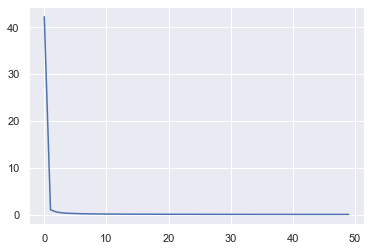

In [67]:
plt.plot(freq_delta)

/Users/craigledgerwood/MachineLearning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':


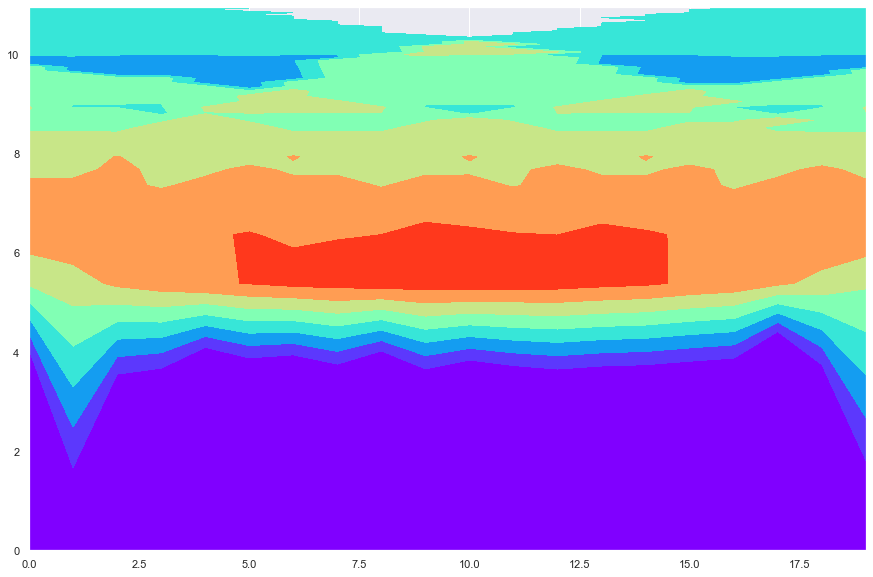

In [71]:
N = dataset['delta'].shape[0]
t0=0
dt=1
time = np.arange(0, N) * dt + t0

power = (abs(coeff_delta))**2
period = 1. / freq_delta
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
contourlevels = np.log2(levels)

fig, ax = plt.subplots(figsize=(15, 10))
im = ax.contourf(time, np.log2(scales), np.log2(power), contourlevels, extend='both',cmap=plt.cm.rainbow)

##### time_step = 50
dataset = series_to_supervised(dataset[['delta', 'volume_norm']].values, n_in=time_step, n_out=1, dropnan=True)

In [8]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size,:].values, dataset.iloc[train_size:,:].values

In [9]:
# split into input and outputs
train_X, train_y = train[:, :-2], train[:, -2:-1]
test_X, test_y = test[:, :-2], test[:, -2:-1]
print(train_X.shape,train_y.shape)

(46, 100) (46, 1)


In [12]:
train_X

array([[[ 0.06203808,  0.29979878],
        [ 0.04104452,  0.18558269],
        [-0.0204845 ,  0.24405678],
        ...,
        [ 0.02137066,  0.3360037 ],
        [ 0.0216219 ,  0.28664896],
        [-0.12561867,  0.37538608]],

       [[ 0.04104452,  0.18558269],
        [-0.0204845 ,  0.24405678],
        [ 0.00262504,  0.17664999],
        ...,
        [ 0.0216219 ,  0.28664896],
        [-0.12561867,  0.37538608],
        [ 0.04409421,  0.29348404]],

       [[-0.0204845 ,  0.24405678],
        [ 0.00262504,  0.17664999],
        [-0.09695996,  0.3719545 ],
        ...,
        [-0.12561867,  0.37538608],
        [ 0.04409421,  0.29348404],
        [-0.04846195,  0.29444606]],

       ...,

       [[ 0.0118357 ,  0.315111  ],
        [ 0.01084131,  0.2573053 ],
        [-0.08038162,  0.22170275],
        ...,
        [-0.04419119,  0.3810812 ],
        [ 0.07112305,  0.35881128],
        [ 0.03654852,  0.31162802]],

       [[ 0.01084131,  0.2573053 ],
        [-0.08038162,  0.22

In [10]:

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], time_step, 2))
test_X = test_X.reshape((test_X.shape[0], time_step, 2))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(46, 50, 2) (46, 1) (24, 50, 2) (24, 1)


In [14]:
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(100))
model.add(Dense(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# # inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# # inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)

ValueError: Input 0 is incompatible with layer lstm_3: expected ndim=3, found ndim=2

In [ ]:
rmse = np.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)

In [ ]:
pyplot.scatter(np.sign(yhat), np.sign(test_y))

In [ ]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(np.sign(yhat), np.sign(test_y))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Down','Up'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Down','Up'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# def generator(marketdata,newsdata, assets, featuresMarket, featuresNews,  n_out):
#     i = 0
#     while True:
#         a = assets[i]
#         d = marketdata.loc[marketdata['assetName']== a, featuresMarket]
#         n = newsdata.loc[newsdata['assetName']== a, featuresNews].values
#         if len(d.index) < 37 or n.shape[0] ==0:
#             continue
            
#         d['RSI'] = LagguerreRSI(d['close'],0.8)
#         d = d.values
#         news, market, output = n, d[:-n_out, :], d[-n_out:, 3]
#         i =+ 1
#         yield [news.reshape(1,news.shape[0],news.shape[1]), market.reshape(1,market.shape[0],market.shape[1])], output

In [ ]:
def forecast(model, data, n_forecast):
    x = np.array([data])
    for _ in range(n_forecast):
        x1 = model.predict(x)
        x2 = np.append(x,np.array([x1]), axis=1)
        x = x2[:,1:,:]
    
    return x[:,-n_forecast:,:]

In [2]:
# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, LSTM, RepeatVector,TimeDistributed,ConvLSTM2D

 
# split a univariate dataset into train/test sets
def split_dataset(data):
    train_size = int(len(data) * 0.67)
    test_size = len(data) - train_size
    train, test = data[0:train_size,:], data[train_size:,:]
	# restructure into windows of weekly data
# 	train = array(split(train, len(train)/7))
# 	test = array(split(test, len(test)/7))
    return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
 
# train the model
def build_model(train, n_steps, n_length, n_input, n_output):
	# prepare data
	train_x, train_y = to_supervised(train, n_input, n_output)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 
# make a forecast
def forecast(model, history, n_steps, n_length, n_input, n_output):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [samples, time steps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input,n_output):
	# fit model
	model = build_model(train, n_steps, n_length, n_input, n_output)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_steps, n_length, n_input, n_output)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, predictions
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
